In [10]:
import os
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import utils_plots as ut

In [11]:
perc = 75
predictors_type = 'original+detrend' # 'original', 'deseason', 'detrend', 'original+detrend' (original predictions, detrended for timeseries comparison)
# Set parameters for run name
if predictors_type == 'original' or predictors_type == 'original+detrend':
    n_clusters_dict = {'NEP': 7, 'NWP': 10, 'NA': 6, 'NI': 7, 'SI': 6, 'SP': 9}
    str_pt = 'nc'
elif predictors_type == 'deseason':
    n_clusters_dict = {'NEP': 6, 'NWP': 10, 'NA': 10, 'NI': 8, 'SI': 8, 'SP': 9}
    str_pt = 'DSnc'
elif predictors_type == 'detrend':
    n_clusters_dict = {'NEP': 12, 'NWP': 10, 'NA': 12, 'NI': 11, 'SI': 7, 'SP': 10}
    str_pt = 'DTnc'

In [12]:
# Set years range and number of folds
years = np.arange(1980, 2022, 1) # from 1980 to 2021 included
n_folds = 3
# Set directories and file paths, then load file containing predictors and target
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
fs_dir = os.path.join(project_dir, 'FS_TCG')

In [21]:
basins = ['NEP', 'NWP', 'NA', 'NI', 'SI', 'SP']
for b, basin in enumerate(basins):
    # Set the predictors data and the target
    n_clusters = n_clusters_dict[basin]
    run_name = f'selfeat{perc}_top20_{str_pt}{n_clusters}_nv8_nd9'
    if predictors_type == 'deseason':
        cluster_data = f'{basin}_{n_clusters}clusters_deseason'
        target_file = 'target_deseasonal_1980-2022_2.5x2.5.csv'
    elif predictors_type == 'detrend':
        cluster_data = f'{basin}_{n_clusters}clusters_detrend'
        target_file = 'target_detrend_1980-2022_2.5x2.5.csv'
    elif predictors_type == 'original+detrend':
        cluster_data = f'{basin}_{n_clusters}clusters_detrend'
        target_file = 'target_detrend_1980-2022_2.5x2.5.csv'
    else:
        cluster_data = f'{basin}_{n_clusters}clusters'
        target_file = 'target_1980-2022_2.5x2.5.csv'
    cluster_data_dir = os.path.join(fs_dir, 'data', cluster_data)
    # target
    target_df = pd.read_csv(os.path.join(cluster_data_dir, target_file), index_col=0)
    target_df.index = pd.to_datetime(target_df.index)
    target_df = target_df.loc[target_df.index.year.isin(years)]
    # Get the run info and data
    Y_pred, Y_pred_noFS, _, _, mlps, mlps_noFS, _ = ut.runs_info(basin, run_name, project_dir)
    # Convert list of dataframes to a single dataframe
    Y_pred_df = pd.concat(Y_pred)
    Y_pred_noFS_df = pd.concat(Y_pred_noFS)
    # If predictions with original data are negative, set them to 0
    if predictors_type == 'original' or predictors_type == 'original+detrend':
        Y_pred_df[Y_pred_df < 0] = 0.0
        Y_pred_noFS_df[Y_pred_noFS_df < 0] = 0.0
    # Sum the predictions for each basin
    if b == 0:
        Y_pred_sum = Y_pred_df
        Y_pred_noFS_sum = Y_pred_noFS_df
        target_df_sum = target_df
    else:
        Y_pred_sum += Y_pred_df
        Y_pred_noFS_sum += Y_pred_noFS_df
        target_df_sum += target_df
# gpis
gpis_file = f'GLB_2.5x2.5_gpis_time_series.csv'
gpis_path = os.path.join(fs_dir, 'data', gpis_file)
gpis_df = pd.read_csv(gpis_path, index_col=0)
gpis_df.index = pd.to_datetime(gpis_df.index)
gpis_df = gpis_df.loc[gpis_df.index.year.isin(years)]
# If predictions for original + detrend remove trend
if predictors_type == 'original+detrend':
    decomp_pred = STL(Y_pred_sum).fit()
    decomp_pred_noFS = STL(Y_pred_noFS_sum).fit()
    Y_pred_sum_df = Y_pred_sum.copy()
    Y_pred_noFS_sum_df = Y_pred_noFS_sum.copy()
    Y_pred_sum_df['tcg'] = Y_pred_sum['tcg'] - decomp_pred.trend
    Y_pred_noFS_sum_df['tcg'] = Y_pred_noFS_sum['tcg'] - decomp_pred_noFS.trend

**Time series Trajectories**

In [26]:
# Annual data without trend and seasonality
target_df_annual = target_df_sum.groupby(target_df_sum.index.year).sum()
Y_pred_df_annual = Y_pred_sum_df.groupby(Y_pred_sum_df.index.year).sum()
Y_pred_noFS_df_annual = Y_pred_noFS_sum_df.groupby(Y_pred_noFS_sum_df.index.year).sum()
# GPIs time series with trend and seasonality
engpi_TS = gpis_df['engpi']
ogpi_TS = gpis_df['ogpi']
# GPIs time series without trend and seasonality
decomp_engpi = STL(engpi_TS).fit()
decomp_ogpi = STL(ogpi_TS).fit()
if predictors_type == 'deseason':
    engpi = engpi_TS - decomp_engpi.seasonal
    ogpi = ogpi_TS - decomp_ogpi.seasonal
elif predictors_type == 'detrend' or predictors_type == 'original+detrend':
    engpi = engpi_TS - decomp_engpi.trend
    ogpi = ogpi_TS - decomp_ogpi.trend
else:
    engpi = engpi_TS
    ogpi = ogpi_TS
# Annual data of the GPIs
engpi_annual = engpi.groupby(engpi.index.year).sum()
ogpi_annual = ogpi.groupby(ogpi.index.year).sum()
# Compute the correlation coefficient and the MSE between the predictions and the test values
# Monthly 
r, p_value = pearsonr(target_df_sum['tcg'], Y_pred_sum_df['tcg'])
r_noFS, p_value_noFS = pearsonr(target_df_sum['tcg'], Y_pred_noFS_sum_df['tcg'])
r_engpi, p_value_engpi = pearsonr(target_df_sum['tcg'], engpi)
r_ogpi, p_value_ogpi = pearsonr(target_df_sum['tcg'], ogpi)
mse = mean_squared_error(target_df_sum['tcg'], Y_pred_sum_df['tcg'])
mse_noFS = mean_squared_error(target_df_sum['tcg'], Y_pred_noFS_sum_df['tcg'])
mse_engpi = mean_squared_error(target_df_sum['tcg'], engpi)
mse_ogpi = mean_squared_error(target_df_sum['tcg'], ogpi)
# Annual 
rY, p_valueY = pearsonr(target_df_annual['tcg'], Y_pred_df_annual['tcg'])
rY_noFS, p_value_noFSY = pearsonr(target_df_annual['tcg'], Y_pred_noFS_df_annual['tcg'])
rY_engpi, p_value_engpiY = pearsonr(target_df_annual['tcg'], engpi_annual)
rY_ogpi, p_value_ogpiY = pearsonr(target_df_annual['tcg'], ogpi_annual)
mseY = mean_squared_error(target_df_annual['tcg'], Y_pred_df_annual['tcg'])
mseY_noFS = mean_squared_error(target_df_annual['tcg'], Y_pred_noFS_df_annual['tcg'])
mseY_engpi = mean_squared_error(target_df_annual['tcg'], engpi_annual)
mseY_ogpi = mean_squared_error(target_df_annual['tcg'], ogpi_annual)

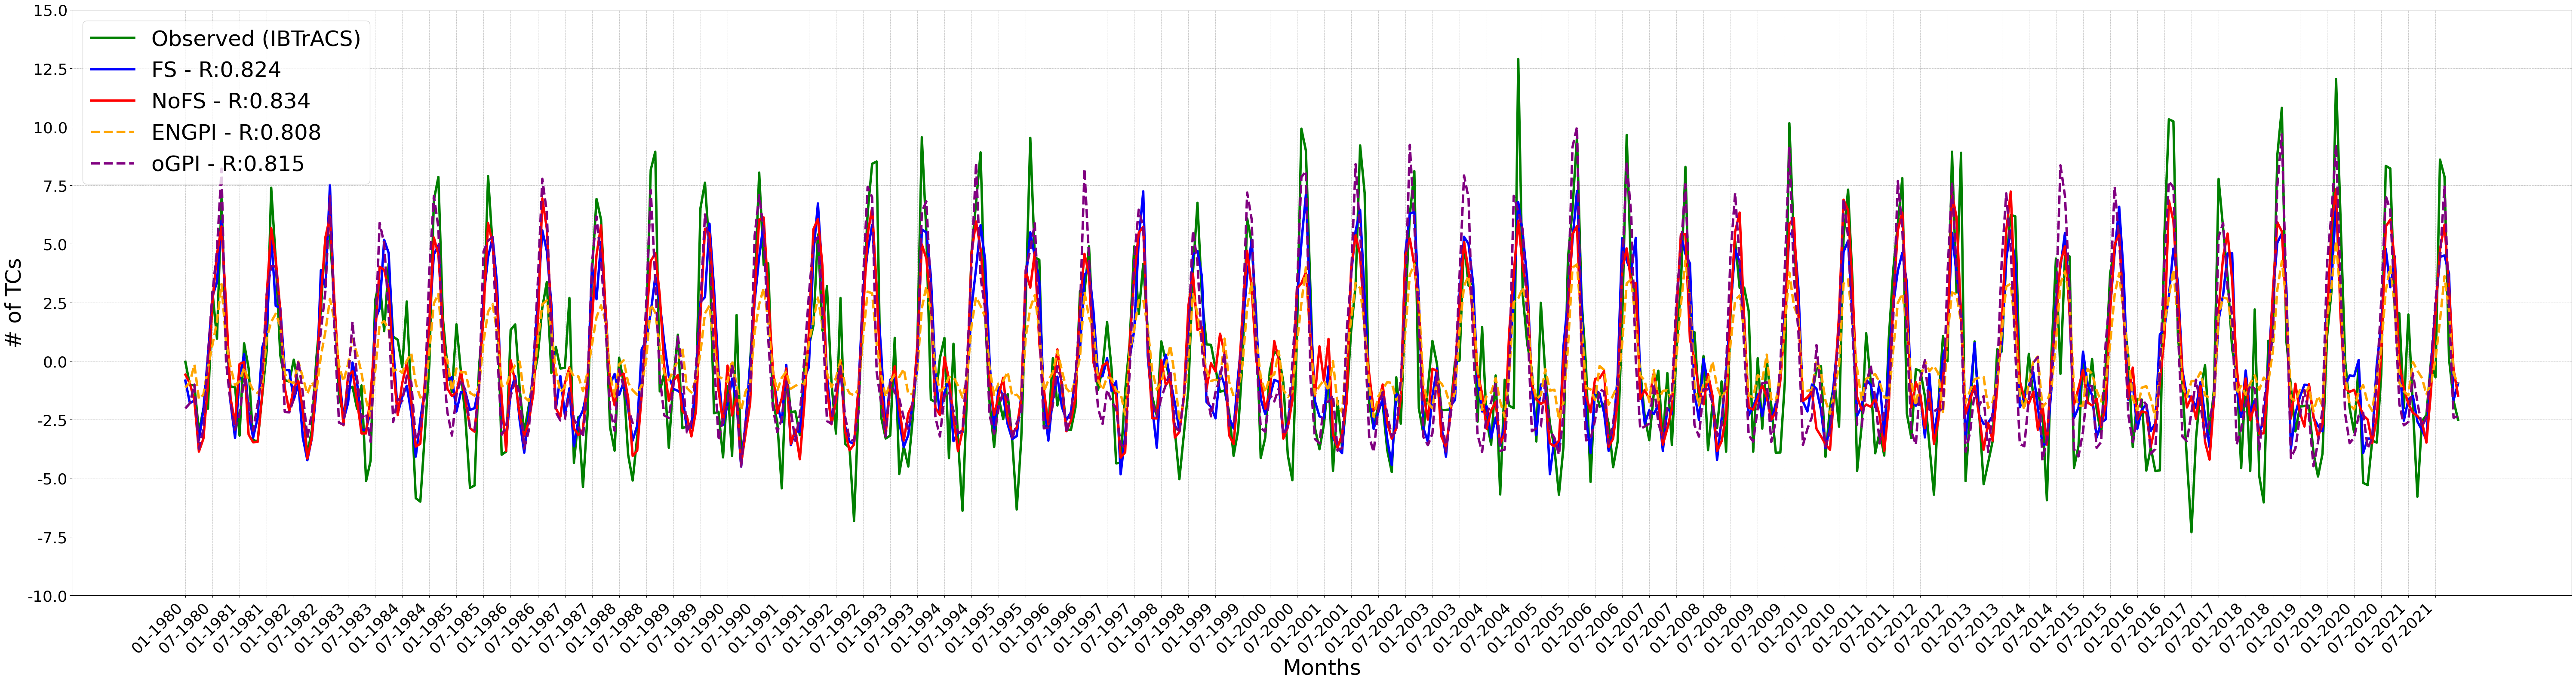

In [27]:
# Plotting the monthly time series 
fig_ts = ut.plot_monthly_time_series(target_df_sum['tcg'], Y_pred_sum_df['tcg'], Y_pred_noFS_sum_df['tcg'], engpi, ogpi, r, r_noFS, r_engpi, r_ogpi)

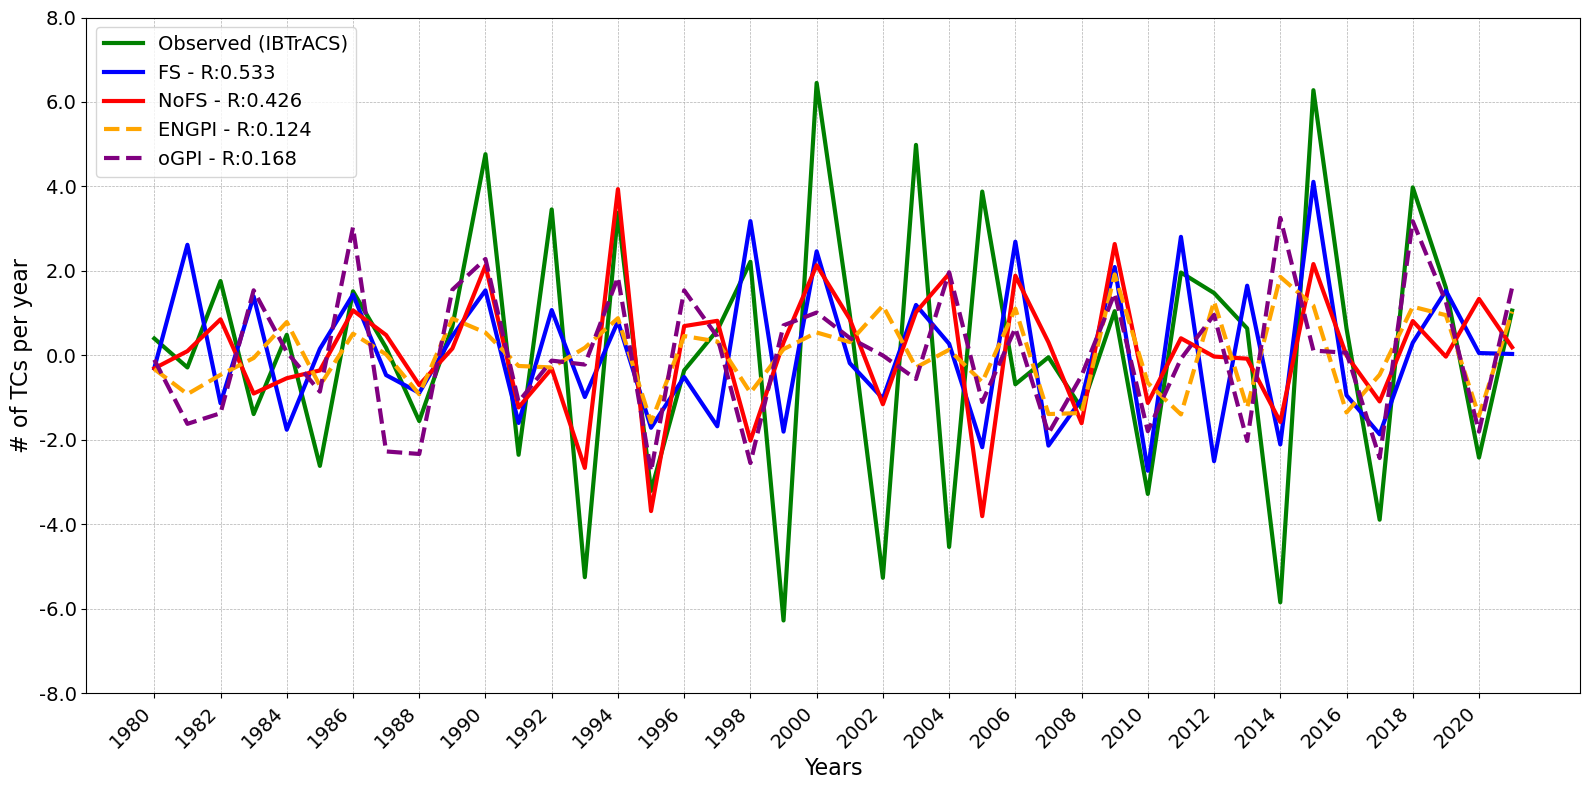

In [28]:
# Plotting the annual time series
fig_annual = ut.plot_annual_time_series(target_df_annual['tcg'], Y_pred_df_annual['tcg'], Y_pred_noFS_df_annual['tcg'], engpi_annual, ogpi_annual, rY, rY_noFS, rY_engpi, rY_ogpi)